In [ ]:
# Importing libraries
import pandas as pd
import re
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [ ]:
# Authenticating and Setting Up BigQuery Client
from google.colab import auth
from google.cloud import bigquery
import csv

auth.authenticate_user()
project_id = "stanford-f24-datasci-194d"
client = bigquery.Client(project=project_id)

**Creating Data Frame**

In [ ]:
# Defining Time Window
hour_start = "2025-02-26 00:00:00"
hour_end = "2025-03-13 00:00:00"

# SQL query
query = f"""
SELECT timestamp, text
FROM `EMS.bsky_firehose_unprocessed`
WHERE timestamp >= '{hour_start}'
AND timestamp < '{hour_end}'
AND (LOWER(text) LIKE '%canada%' OR LOWER(text) LIKE '%trudeau%' OR LOWER(text) LIKE '%canadian%')
ORDER BY timestamp
"""

# Running query and saving to csv
query_result = client.query(query).result()
with open('us_canada_trade_march2025.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Timestamp', 'Text'])  # Write header row

    for row in query_result:
        writer.writerow([row.timestamp, row.text])



**Data Analysis**

In [ ]:
# Loading in full dataset
df = pd.read_csv('us_canada_trade_march2025.csv', parse_dates=['Timestamp'])

# Force-convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Canada + Trade regex pattern
regex_pattern = r'(canada|trudeau|canadian).*(tariff|tariffs|trade war|import tax|exports|sanctions)|(tariff|tariffs|trade war|import tax|exports|sanctions).*(canada|trudeau|canadian)'

# Function to apply regex
def match_canada_trade(text):
    if isinstance(text, str):
        return bool(re.search(regex_pattern, text, flags=re.IGNORECASE))
    return False

# Create a new column for whether the post matches
df['canada_trade_match'] = df['Text'].apply(match_canada_trade)

# Creating before and after cutoff groups
event_date = pd.Timestamp('2025-03-04', tz='UTC')

# Posts before and after March 4, 2025
df_before = df[df['Timestamp'] < event_date]
df_after = df[df['Timestamp'] >= event_date]

# Convert to floats
df_before['canada_trade_match'] = df_before['canada_trade_match'].astype(float)
df_after['canada_trade_match'] = df_after['canada_trade_match'].astype(float)

# Run t-test
t_stat, p_value = stats.ttest_ind(df_before['canada_trade_match'], df_after['canada_trade_match'])

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Calculating means for difference-in-means
mean_before = df_before['canada_trade_match'].mean()
mean_after = df_after['canada_trade_match'].mean()

print(f"Mean match rate before event: {mean_before}")
print(f"Mean match rate after event: {mean_after}")

# Results
t_stat, p_value = stats.ttest_ind(df_before['canada_trade_match'], df_after['canada_trade_match'])

print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: -64.54928270071565, P-value: 0.0
Mean match rate before event: 0.06186082029103418
Mean match rate after event: 0.12365073459663094
T-statistic: -64.54928270071565, P-value: 0.0


<ipython-input-32-3de8deb3bc8e>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_before['canada_trade_match'] = df_before['canada_trade_match'].astype(float)
<ipython-input-32-3de8deb3bc8e>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after['canada_trade_match'] = df_after['canada_trade_match'].astype(float)


**Data Visualization**

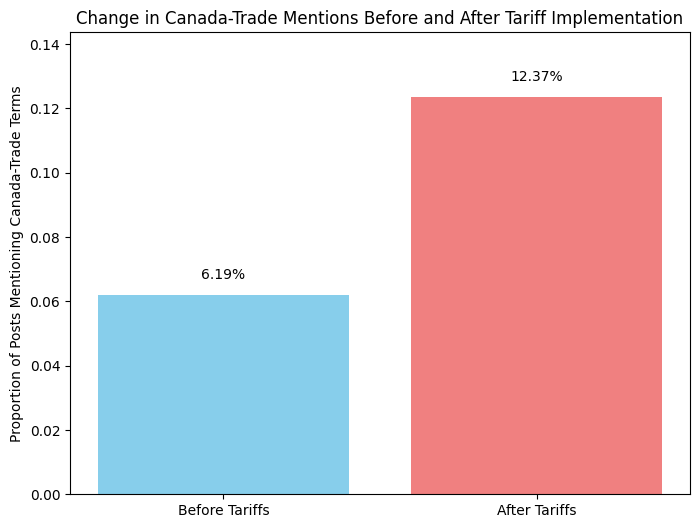

Proportion of posts mentioning Canada-trade before tariffs: 0.0619
Proportion of posts mentioning Canada-trade after tariffs: 0.1237


In [ ]:
# Count number of posts mentioning Canada-trade before and after
tweets_with_trade_before = df_before['canada_trade_match'].sum()
tweets_with_trade_after = df_after['canada_trade_match'].sum()

# Total number of posts before and after
total_tweets_before = len(df_before)
total_tweets_after = len(df_after)

# Proportion of posts mentioning Canada-trade
proportion_before = tweets_with_trade_before / total_tweets_before
proportion_after = tweets_with_trade_after / total_tweets_after

# Plot
plt.figure(figsize=(8, 6))
plt.bar(['Before Tariffs', 'After Tariffs'], [proportion_before, proportion_after], color=['skyblue', 'lightcoral'])

# Add labels and title
plt.ylabel('Proportion of Posts Mentioning Canada-Trade Terms')
plt.title('Change in Canada-Trade Mentions Before and After Tariff Implementation')

# Zoom y-axis to show the jump clearly
plt.ylim(0, max(proportion_before, proportion_after) + 0.02)

# Add values on top of bars
for i, v in enumerate([proportion_before, proportion_after]):
    plt.text(i, v + 0.005, f"{v:.2%}", ha='center', fontsize=10)

plt.show()

# Print proportions
print(f"Proportion of posts mentioning Canada-trade before tariffs: {proportion_before:.4f}")
print(f"Proportion of posts mentioning Canada-trade after tariffs: {proportion_after:.4f}")

**Regression Discontinuity Design**

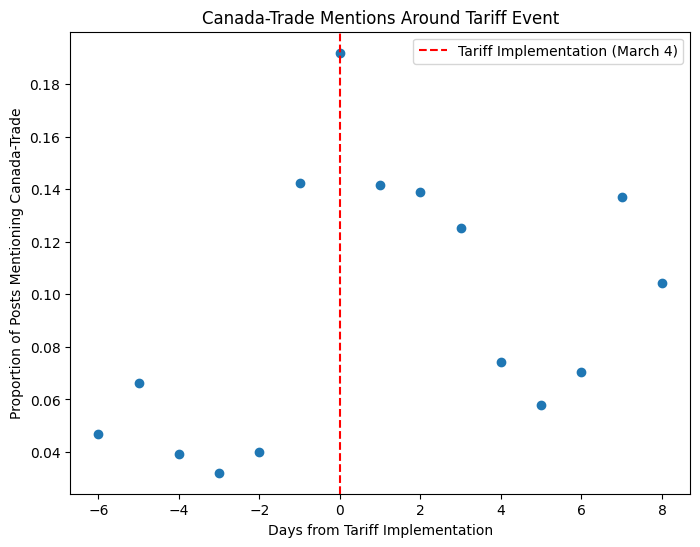

In [ ]:
# Creating a running variable: days relative to the March 4 event
df['days_from_event'] = (df['Timestamp'] - event_date).dt.days

# Group by day and calculate average match rate
daily_avg = df.groupby('days_from_event')['canada_trade_match'].mean()

# Plot
plt.figure(figsize=(8,6))
plt.scatter(daily_avg.index, daily_avg.values)
plt.axvline(x=0, color='red', linestyle='--', label='Tariff Implementation (March 4)')
plt.xlabel('Days from Tariff Implementation')
plt.ylabel('Proportion of Posts Mentioning Canada-Trade')
plt.title('Canada-Trade Mentions Around Tariff Event')
plt.legend()
plt.show()

In [ ]:
# Focus on posts within +/- 7 days around March 4
df_rdd = df[(df['days_from_event'] >= -7) & (df['days_from_event'] <= 7)]

# Create Treatment variable: 0 = before event, 1 = after event
df_rdd['treatment'] = (df_rdd['days_from_event'] >= 0).astype(int)

# Regression: outcome on treatment and running variable
X = sm.add_constant(df_rdd[['days_from_event', 'treatment']])
y = df_rdd['canada_trade_match']

rdd_model = sm.OLS(y, X).fit()
print(rdd_model.summary())

<ipython-input-37-4d2cd77fb260>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rdd['treatment'] = (df_rdd['days_from_event'] >= 0).astype(int)


                            OLS Regression Results                            
Dep. Variable:     canada_trade_match   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3129.
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               0.00
Time:                        03:40:41   Log-Likelihood:            -1.2313e+05
No. Observations:              506507   AIC:                         2.463e+05
Df Residuals:                  506504   BIC:                         2.463e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0328      0.001     

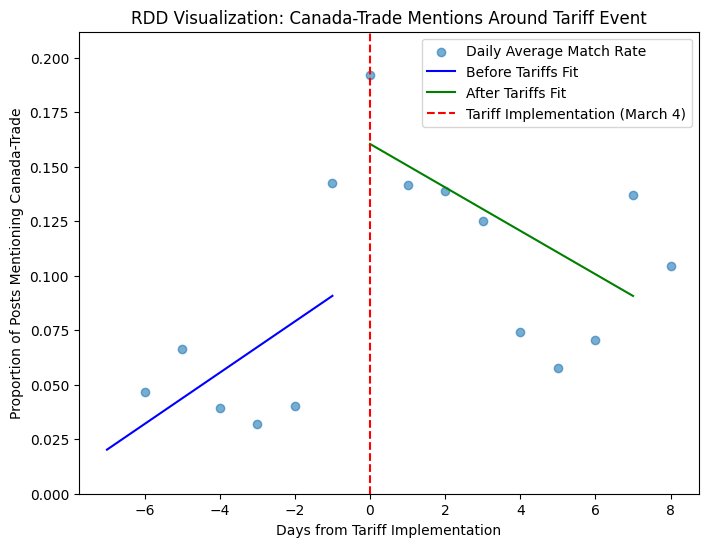

In [ ]:
# Creating a running variable: days relative to the March 4 event
df['days_from_event'] = (df['Timestamp'] - event_date).dt.days

# Group by day and calculate average match rate
daily_avg = df.groupby('days_from_event')['canada_trade_match'].mean()

# Start Plot
plt.figure(figsize=(8,6))

# Scatter daily averages
plt.scatter(daily_avg.index, daily_avg.values, label='Daily Average Match Rate', alpha=0.6)

# Fit regression lines
before = df[df['days_from_event'] < 0]
after = df[df['days_from_event'] >= 0]

# Fit separate simple linear models
before_model = np.polyfit(before['days_from_event'], before['canada_trade_match'], 1)
after_model = np.polyfit(after['days_from_event'], after['canada_trade_match'], 1)

# Create prediction points
x_before = np.linspace(-7, -1, 100)
x_after = np.linspace(0, 7, 100)

y_before = np.polyval(before_model, x_before)
y_after = np.polyval(after_model, x_after)

# Plot the fitted lines
plt.plot(x_before, y_before, color='blue', label='Before Tariffs Fit')
plt.plot(x_after, y_after, color='green', label='After Tariffs Fit')

# Vertical line at event
plt.axvline(x=0, color='red', linestyle='--', label='Tariff Implementation (March 4)')

# Labels and title
plt.xlabel('Days from Tariff Implementation')
plt.ylabel('Proportion of Posts Mentioning Canada-Trade')
plt.title('RDD Visualization: Canada-Trade Mentions Around Tariff Event')
plt.legend()

# y-axis
plt.ylim(0, daily_avg.max() + 0.02)

# Show plot
plt.show()